In [1]:
import netket as nk
import json
from qutip import *
import numpy as np
import time
import multiprocessing as mp
from collections import OrderedDict
from pickle import dump
import os
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from functools import reduce
plt.style.use('seaborn')
from scipy.stats import norm
import sys
sys.path.append("/Users/victorwei/Research projects/Neural Network Quantum State/penalty excited states")
import expect_grad_ex
import vmc_ex
import jax



In [2]:
def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

def exactDiagonalization(hamiltonian):
    # Changes Hamiltonian to matrix form, where hamiltonian of interest is sparse in matrix form
    #haMatrix = hamiltonian.to_sparse()
    # Gets eigenvalues and vectors, where the built-in function uses 
    eigenValues, v = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=True)

    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

# NetKet RBM with stochastic reconfiguration descent
class RBM:
    def __init__(self, N, hamiltonian, hilbertSpace, machine):
        # Assign inputsv[:, i]
        self.hamiltonian, self.hilbertSpace, self.machine, self.N = hamiltonian, hilbertSpace, machine, N
        # Define sampler
        self.sampler = nk.sampler.MetropolisLocal(hilbert=hilbertSpace)
        # Define optimizer
        self.optimizer = nk.optimizer.Sgd(learning_rate=0.05)
        # Define Stochastic reconfiguration
        self.sr = nk.optimizer.SR(diag_shift=0.05) #diagnol shift, its role as regularizer? seems to take a different form as 
        #compared to the version I have seen
        # Variational state
        self.vs = nk.vqs.MCState(self.sampler, self.machine, n_samples=2000, n_discard_per_chain=200) #discarded number of samples 
        #at the beginning of the MC chain

    # Output is the name of the output file in which the descent data is stored
    def __call__(self, output, state_list, shift_list):
        self.vs.init_parameters(jax.nn.initializers.normal(stddev=0.25))
        gs = vmc_ex.VMC_ex(hamiltonian=self.hamiltonian, optimizer=self.optimizer, variational_state=self.vs, preconditioner=self.sr, 
                   state_list = state_list, shift_list = shift_list)
        # Start timing
        start = time.time()
        # Set the output files as well as number of iterations in the descent
        gs.run(out=output, n_iter=500)
        end = time.time()
        runTime = end - start
        # Import the data from log file
        data = json.load(open(output + '.log'))
        # Extract the relevant information
        # iters = data["Energy"]["iters"]
        energy_RBM = data["Energy"]["Mean"]["real"] #get the real part of the mean energy
       
        # finalEng = energy_RBM[-1]
        finalEng = reduce(lambda x, y: x if y is None else y, energy_RBM)
        # Get machine statethe state of the machine as an array
        #state = self.vs.to_array()
        # Outputs the final energy, the final state, and the runtime
        #parameters = self.vs.parameters
        # Outputs the final energy, the final state, and the runtime
        return finalEng, runTime
    
# Error Calculation (Input: the found state, the state from exact diagonalization, the found energy, the energy from exact diagonalization)
def err(state, edState, eng, edEng,N):
    engErr = np.abs(eng - edEng)
    overlap = np.dot(state.conj().reshape(2**N, 1).T, edState.reshape(2**N, 1))
    waveFunctionErr = 1 - (np.linalg.norm(overlap))**2
    return engErr, waveFunctionErr


# Combines all steps into a function to run on the cluster
def runDescentCS(N,B,Ak,alpha, state_list, shift_list):
    # Define hamiltonian and hibert space (need to do this here cause can't use netket objects as input to use multiprocessing functions)
    ha, hi = CSHam(N,B,Ak)
    # RBM Spin Machine
    ma = nk.models.RBM(alpha=1, dtype=complex,use_visible_bias=True, use_hidden_bias=True)
    # Initialize RBM
    rbm = RBM(N, ha, hi, ma) #an instance of class RBM
    # Run RBM
    eng, runTime = rbm("2021_summer_data/Logs"+str(N), state_list, shift_list) #where _call_ will be invoked
    return eng, runTime


In [12]:
#Data extraction for exact_full, exact_lan, and SR
N = [2,4,6,8,10,12,14,16,18,20,22,24,26]
Time_list = []
for N_i in N:
    
    Ak = []

    alpha = 1   #density of RBM
    M = alpha*N_i
    # Constant A
    B = 0.95
    # Variable A
    A = N_i/2
    N0 = N_i/2
    for i in range(N_i-1):
        # Constant A
        Ak_i = 1
        # Variable A
        #Ak_i = A / (N0) * np.exp(-i / N0)
        Ak.append(Ak_i)

    # Define hamiltonian and hilbert space
    ha, hi = CSHam(N_i,B,Ak)


    #Exact Diagonalization
    #e, v = exactDiagonalization_full(ha)

    ma = nk.models.RBM(alpha=1, dtype=complex,use_visible_bias=True, use_hidden_bias=True)
    sampler = nk.sampler.MetropolisLocal(hilbert=hi)
    vs1 = nk.vqs.MCState(sampler, ma, n_samples=2000, n_discard_per_chain=200)
    vs1.init_parameters(jax.nn.initializers.normal(stddev=0.25))
    state_list = [vs1]
    shift_list = [0]
    
    eng, runTime = runDescentCS(N_i,B,Ak,alpha, state_list, shift_list)
    Time_list.append(runTime)


100%|█| 500/500 [00:05<00:00, 99.74it/s, Energy=-0.93929-0.00002j ± 0.00036 [σ²=
100%|█| 500/500 [00:12<00:00, 38.49it/s, Energy=-1.55266-0.00003j ± 0.00049 [σ²=
100%|█| 500/500 [00:22<00:00, 22.30it/s, Energy=-2.0965+0.0001j ± 0.0027 [σ²=0.0
100%|█| 500/500 [00:38<00:00, 12.89it/s, Energy=-2.6164+0.0001j ± 0.0043 [σ²=0.0
100%|█| 500/500 [01:00<00:00,  8.31it/s, Energy=-3.1325+0.0000j ± 0.0052 [σ²=0.0
100%|█| 500/500 [01:27<00:00,  5.69it/s, Energy=-3.6355+0.0004j ± 0.0037 [σ²=0.0
100%|█| 500/500 [01:49<00:00,  4.57it/s, Energy=-4.1464-0.0012j ± 0.0098 [σ²=0.1
100%|█| 500/500 [02:27<00:00,  3.38it/s, Energy=-4.5856+0.0002j ± 0.0016 [σ²=0.0
100%|█| 500/500 [03:17<00:00,  2.54it/s, Energy=-5.1024-0.0001j ± 0.0014 [σ²=0.0
100%|█| 500/500 [03:26<00:00,  2.42it/s, Energy=-5.6786+0.0006j ± 0.0013 [σ²=0.0
100%|█| 500/500 [04:01<00:00,  2.07it/s, Energy=-6.166-0.000j ± 0.010 [σ²=0.213,
100%|█| 500/500 [05:25<00:00,  1.54it/s, Energy=-6.2244-0.0010j ± 0.0014 [σ²=0.0
100%|█| 500/500 [05:51<00:00

In [13]:
#save the file of Time_list
fileName = "Time_data.json"
open(fileName, "w").close()
with open(fileName, 'a') as file:
    file.write(json.dumps(Time_list))
print('Saved')

Saved


In [10]:
#load the saved data here
fileName = "Time_data.json"
f = open(fileName)
Time_list = json.load(f)
print(Time_list)

N = [2,4,6,8,10,12,14,16,18,20,22,24,26]
N_ed = [2,3,4,5,6,7,8,9,10,11,12]

[5.0350236892700195, 20.60049295425415, 28.196250677108765, 46.59344792366028, 66.14241695404053, 93.88131785392761, 115.47137880325317, 156.20106601715088, 203.5060260295868, 213.3438630104065, 247.71038508415222, 331.7767827510834, 358.14309883117676]


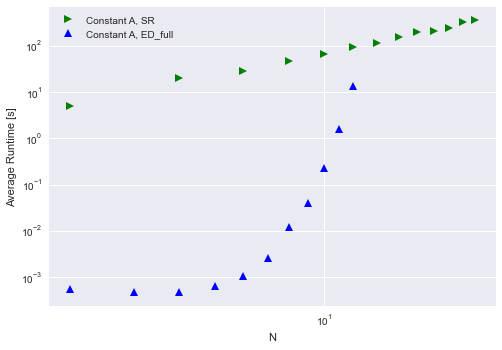

In [12]:
#plot all of them together, log-log-scale
exact_full = [0.0005525588989257812, 0.00047042369842529295, 0.0004702091217041016, 0.0006253957748413086, 0.0010281801223754883, 0.002562260627746582, 0.012175846099853515, 0.03916521072387695, 0.22497975826263428, 1.5928212404251099, 13.569981551170349]
plt.plot(N,Time_list,'g>',markersize=8,label='Constant A, SR')
plt.plot(N_ed,exact_full, 'b^',markersize=8,label='Constant A, ED_full ')
#plt.plot(N,exact_lan, 'r^',markersize=8,label='Constant A, ED_lan ')
#plt.yscale('log')
plt.ylabel('Average Runtime [s]')
plt.xlabel('N')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [17]:
def quadratic(x,a,b,c):
    y = a*x**2+b*x+c
    return y

def linear(x,a,b):
    y = a*x+b
    return y

op_2, cov_2 = scipy.optimize.curve_fit(quadratic, N, Time_list, p0 = [0.3,7,-18])
op_1, cov_1 = scipy.optimize.curve_fit(linear, N, Time_list, p0 = [10,2])
print(op_2,'\n', cov_2)
print('\n')
print(op_1,'\n', cov_1)

[ 0.44381128  2.3806596  -0.04648034] 
 [[ 3.90421046e-03 -1.09318238e-01  5.46588474e-01]
 [-1.09318238e-01  3.23272239e+00 -1.77097514e+01]
 [ 5.46588474e-01 -1.77097514e+01  1.19815742e+02]]


[ 14.80737541 -62.18005953] 
 [[  0.94405086 -13.21671214]
 [-13.21671214 237.90082378]]


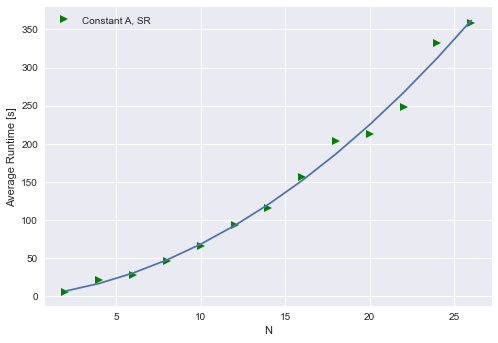

In [19]:
plt.plot(N,Time_list,'g>',markersize=8,label='Constant A, SR')
plt.plot(N, quadratic(np.array(N),*op_2))
#plt.plot(N, linear(np.array(N),*op_1))
plt.ylabel('Average Runtime [s]')
plt.xlabel('N')
plt.legend()
plt.show()